In [1]:
# Colab Cell 1: Install build-essential (includes g++)
!sudo apt-get update
!sudo apt-get install -y build-essential
print("System build tools (including g++) installed.")

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,918 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 2,307 kB in 1s (1,944 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repositor

In [1]:
# ==============================================================================
# Cell 1: Environment Setup and Data Loading
# ==============================================================================

# 1. Install necessary Python packages
print("Installing Python packages...")
# We install pymc, arviz, and other common data science libraries
# The provided code for installing build-essential is often not strictly
# necessary for the latest PyMC on Colab but is good practice.
!pip install pymc arviz matplotlib pandas seaborn --no-deps

# 2. Import libraries and mount Google Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import os
from google.colab import drive

print("\nMounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

# Define the path to your data folder in Google Drive
# Make sure this path is exactly where your CSV file is located
GOOGLE_DRIVE_DATA_PATH = '/content/drive/MyDrive/Colab_Project_Data'
print(f"Google Drive data path set to: {GOOGLE_DRIVE_DATA_PATH}")

# Define the file name and full path
# *** IMPORTANT: Change this to your actual file name if it's different ***
FILE_NAME = 'BrentOilPrices.csv'
file_path = os.path.join(GOOGLE_DRIVE_DATA_PATH, FILE_NAME)

# 3. Load the data
try:
    df = pd.read_csv(file_path, parse_dates=['Date'])
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please check the file name and path in the code.")
    raise

# Ensure the DataFrame has 'Date' and 'Price' columns
if 'Date' not in df.columns or 'Price' not in df.columns:
    raise ValueError("DataFrame must contain 'Date' and 'Price' columns.")

# Set the Date as the index and sort it
df = df.set_index('Date').sort_index()

print("\nData loading and setup complete.")

Installing Python packages...

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.
Google Drive data path set to: /content/drive/MyDrive/Colab_Project_Data


/tmp/ipython-input-3413046360.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Date'])


Data loaded successfully.

Data loading and setup complete.


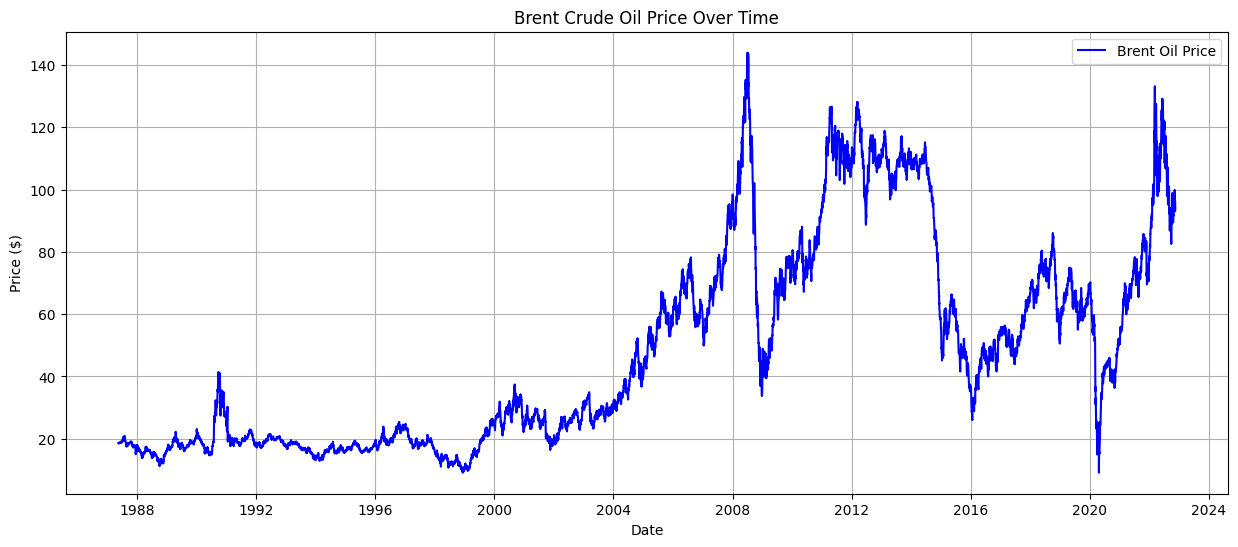

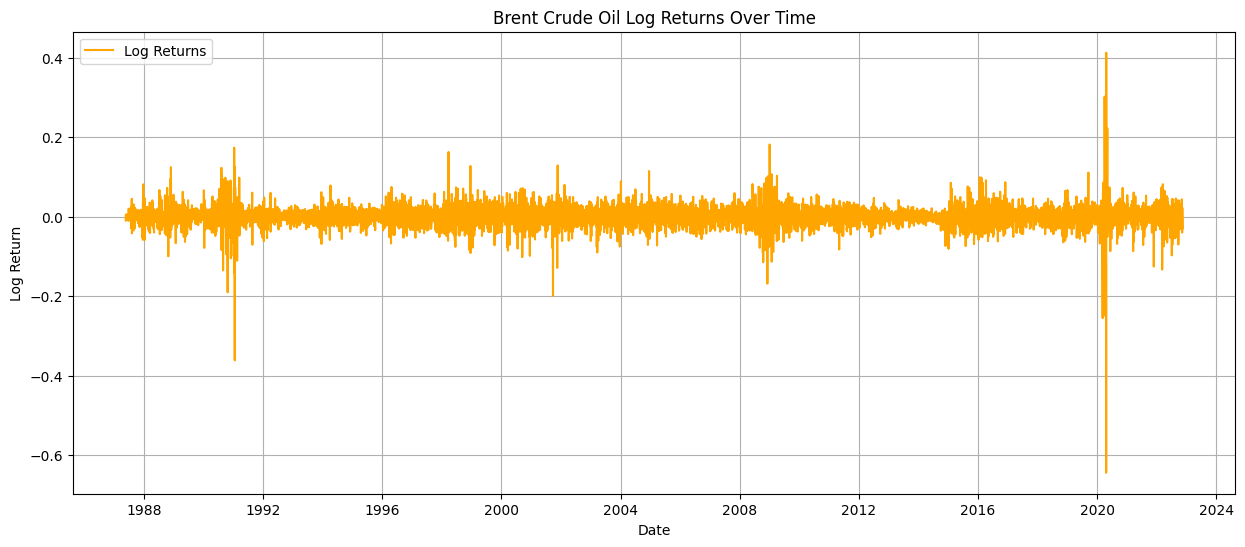

EDA and data preparation complete.


In [2]:
# ==============================================================================
# Cell 2: Data Preparation and Exploratory Data Analysis (EDA)
# ==============================================================================

# Plot the raw Brent oil price series
plt.figure(figsize=(15, 6))
plt.plot(df['Price'], label='Brent Oil Price', color='blue')
plt.title('Brent Crude Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

# Calculate log returns for a stationary time series
# This creates a new DataFrame with the correct index for plotting
log_returns_df = pd.DataFrame(index=df.index[1:])
log_returns_df['Log_Return'] = np.log(df['Price']).diff().dropna()
log_returns = log_returns_df['Log_Return'].values
n_points = len(log_returns)

# Plot the log returns to visualize volatility clustering
plt.figure(figsize=(15, 6))
# Use the index of the new log_returns_df for a perfect match
plt.plot(log_returns_df.index, log_returns, label='Log Returns', color='orange')
plt.title('Brent Crude Oil Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.show()

print("EDA and data preparation complete.")

In [3]:
# ==============================================================================
# Cell 3: Building and Running the Bayesian Change Point Model
# ==============================================================================

print("\nBuilding PyMC model...")
with pm.Model() as change_point_model:
    # Define the unknown change point (tau) as a discrete uniform prior
    # It can happen on any day (index) of the log returns series
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_points - 1)

    # Priors for the mean (mu) and volatility (sigma) before the change
    mu_before = pm.Normal("mu_before", mu=0, sigma=0.1)
    sigma_before = pm.HalfNormal("sigma_before", sigma=1)

    # Priors for the mean (mu) and volatility (sigma) after the change
    mu_after = pm.Normal("mu_after", mu=0, sigma=0.1)
    sigma_after = pm.HalfNormal("sigma_after", sigma=1)

    # A switch function to apply different parameters before and after tau
    t = np.arange(n_points)
    mu_switched = pm.math.switch(t < tau, mu_before, mu_after)
    sigma_switched = pm.math.switch(t < tau, sigma_before, sigma_after)

    # The likelihood function connects the model parameters to the observed data
    y_obs = pm.Normal(
        "y_obs",
        mu=mu_switched,
        sigma=sigma_switched,
        observed=log_returns,
    )

print("Starting MCMC sampling...")
with change_point_model:
    # Run the sampler to find the posterior distributions
    # `draws` is the number of samples, `tune` is the number of tuning steps
    trace = pm.sample(draws=2000, tune=1000, chains=4, cores=4, return_inferencedata=True)
print("Sampling complete.")


Building PyMC model...
Starting MCMC sampling...


Output()

Sampling complete.



--- Model Summary and Convergence Diagnostics ---
                  mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
tau           5388.497  21.717  5348.000  5422.000      0.775    0.626   
mu_before        0.000   0.000    -0.000     0.001      0.000    0.000   
mu_after        -0.000   0.000    -0.001     0.001      0.000    0.000   
sigma_before     0.023   0.000     0.023     0.023      0.000    0.000   
sigma_after      0.029   0.000     0.028     0.029      0.000    0.000   

              ess_bulk  ess_tail  r_hat  
tau              923.0    1111.0    1.0  
mu_before       9941.0    6382.0    1.0  
mu_after       12727.0    6469.0    1.0  
sigma_before   13450.0    6749.0    1.0  
sigma_after    13963.0    6598.0    1.0  


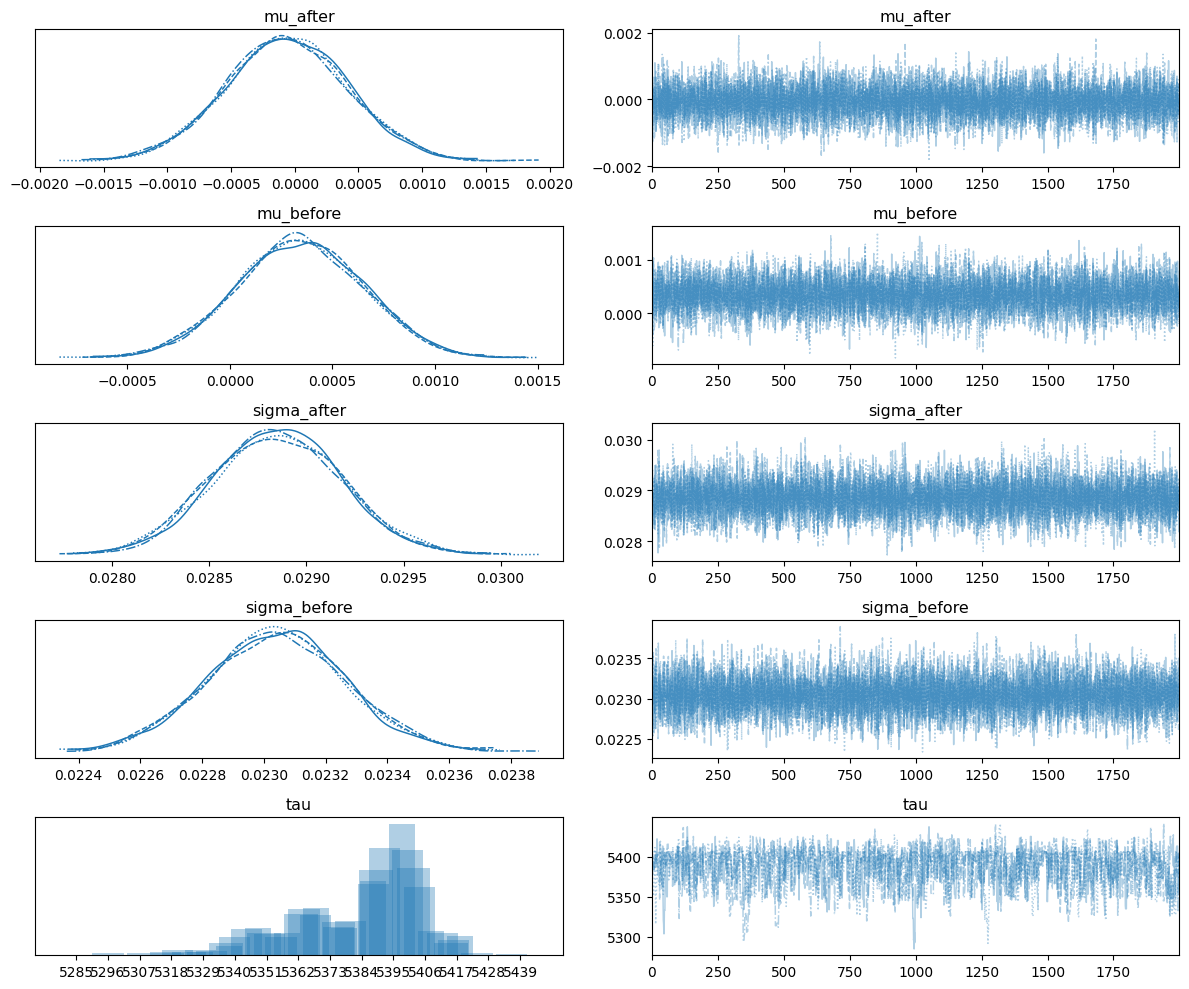


Most probable change point occurred on index: 5406
This corresponds to the date: 2008-08-21


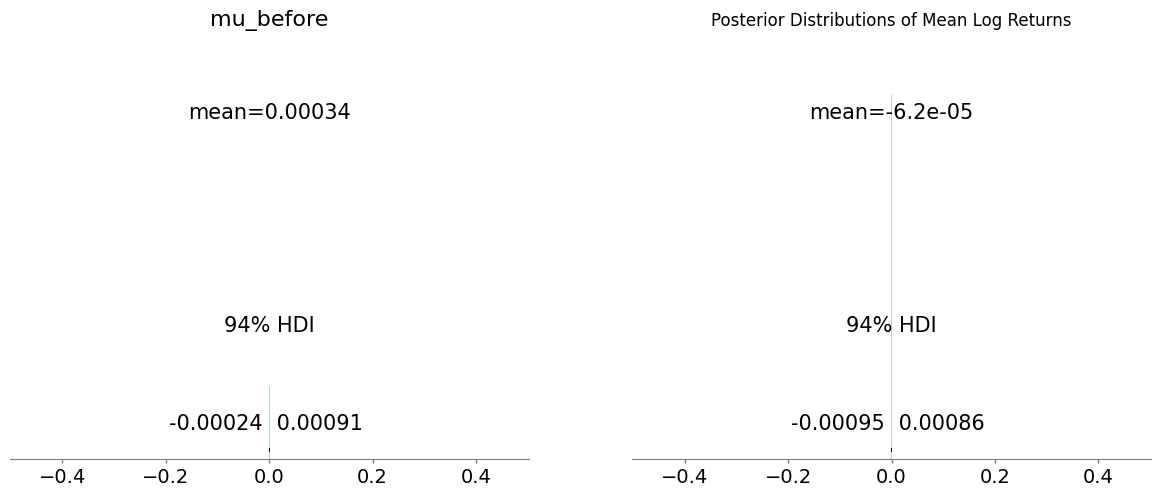

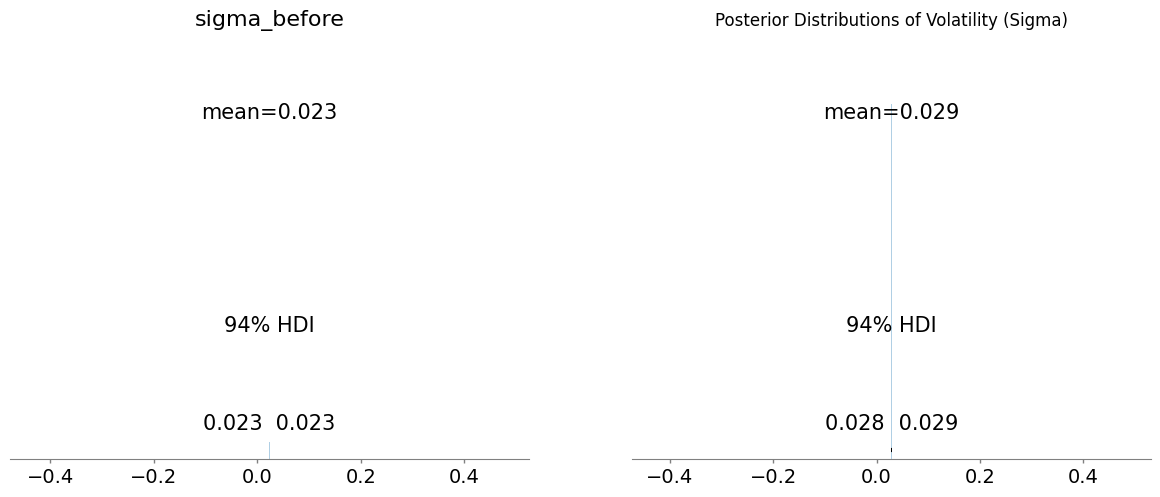


--- Quantitative Impact Analysis ---
Mean log return BEFORE change: 0.0003
Mean log return AFTER change: -0.0001
Average percentage change in price after the change point: -0.04%
Probability that the mean log return increased: 23.39%
Probability that volatility (sigma) increased: 100.00%


In [4]:
# ==============================================================================
# Cell 4: Interpreting the Model Output
# ==============================================================================

# Check convergence diagnostics
print("\n--- Model Summary and Convergence Diagnostics ---")
print(az.summary(trace, var_names=["tau", "mu_before", "mu_after", "sigma_before", "sigma_after"]))

# Plot the posterior distributions to visually check convergence
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Identify the most probable change point date
tau_samples = trace.posterior['tau'].values.flatten()
most_probable_tau = pd.Series(tau_samples).mode()[0]
change_point_date = log_returns_df.index[most_probable_tau]

print(f"\nMost probable change point occurred on index: {most_probable_tau}")
print(f"This corresponds to the date: {change_point_date.strftime('%Y-%m-%d')}")

# Visualize the posterior distributions for the parameters
az.plot_posterior(trace, var_names=["mu_before", "mu_after"], kind="hist")
plt.title('Posterior Distributions of Mean Log Returns')
plt.show()

az.plot_posterior(trace, var_names=["sigma_before", "sigma_after"], kind="hist")
plt.title('Posterior Distributions of Volatility (Sigma)')
plt.show()

# Quantify the impact of the change point
mu_before_samples = trace.posterior['mu_before'].values.flatten()
mu_after_samples = trace.posterior['mu_after'].values.flatten()
sigma_before_samples = trace.posterior['sigma_before'].values.flatten()
sigma_after_samples = trace.posterior['sigma_after'].values.flatten()

# Calculate the average percentage change in price after the change point
price_change_percentage = (np.exp(mu_after_samples.mean() - mu_before_samples.mean()) - 1) * 100

print("\n--- Quantitative Impact Analysis ---")
print(f"Mean log return BEFORE change: {mu_before_samples.mean():.4f}")
print(f"Mean log return AFTER change: {mu_after_samples.mean():.4f}")
print(f"Average percentage change in price after the change point: {price_change_percentage:.2f}%")

# Calculate the probability that the mean and volatility increased
prob_mu_increase = (mu_after_samples > mu_before_samples).mean() * 100
prob_sigma_increase = (sigma_after_samples > sigma_before_samples).mean() * 100
print(f"Probability that the mean log return increased: {prob_mu_increase:.2f}%")
print(f"Probability that volatility (sigma) increased: {prob_sigma_increase:.2f}%")